# Abandono de empleados

## Importacion de paquetes

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
%matplotlib inline

## Carga de los datos

In [3]:
df = pd.read_csv('AbandonoEmpleados.csv', sep = ';', index_col = 'id', na_values = '#N/D')
df.head()

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,empleados,satisfaccion_entorno,sexo,...,satisfaccion_companeros,horas_quincena,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,conciliacion,anos_compania,anos_en_puesto,anos_desde_ult_promocion,anos_con_manager_actual
id,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,Sales,1,Universitaria,Life Sciences,1,Media,3.0,...,Baja,80,0,8,0,NaN,6,NaN,0,5
2,49,No,Travel_Frequently,Research & Development,8,Secundaria,Life Sciences,1,Alta,2.0,...,Muy_Alta,80,1,10,3,NaN,10,NaN,1,7
4,37,Yes,Travel_Rarely,Research & Development,2,Secundaria,Other,1,Muy_Alta,2.0,...,Media,80,0,7,3,NaN,0,2.0,0,0
5,33,No,Travel_Frequently,Research & Development,3,Universitaria,Life Sciences,1,Muy_Alta,3.0,...,Alta,80,0,8,3,NaN,8,3.0,3,0
7,27,No,Travel_Rarely,Research & Development,2,Universitaria,Medical,1,Baja,3.0,...,Muy_Alta,80,1,6,3,NaN,2,NaN,2,2


## Preprocesamiento

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   object 
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1369 non-null   object 
 6   carrera                   1470 non-null   object 
 7   empleados                 1470 non-null   int64  
 8   satisfaccion_entorno      1470 non-null   object 
 9   sexo                      1271 non-null   float64
 10  implicacion               1452 non-null   object 
 11  nivel_laboral             1470 non-null   int64  
 12  puesto                    1470 non-null   object 
 13  satisfaccion_trabajo      1394 non-null   object 
 14  estado_civil 

In [5]:
df.isna().sum().sort_values(ascending = False)

anos_en_puesto              1238
conciliacion                1011
sexo                         199
educacion                    101
satisfaccion_trabajo          76
implicacion                   18
edad                           0
nivel_acciones                 0
evaluacion                     0
satisfaccion_companeros        0
horas_quincena                 0
anos_experiencia               0
horas_extra                    0
num_formaciones_ult_ano        0
anos_compania                  0
anos_desde_ult_promocion       0
incremento_salario_porc        0
salario_mes                    0
mayor_edad                     0
num_empresas_anteriores        0
abandono                       0
estado_civil                   0
puesto                         0
nivel_laboral                  0
satisfaccion_entorno           0
empleados                      0
carrera                        0
distancia_casa                 0
departamento                   0
viajes                         0
anos_con_m

Se puede notar que
* anos_en_puesto y conciliacion tienen demasiados nulos tal que vamos a eliminar dichas variables.
* sexo, educacion, satisfaccion_trabajo e implicacion tiene un bajo valor de nulos, por lo que se pueden imputar.

In [6]:
df.drop(columns = ['anos_en_puesto','conciliacion'], inplace = True)

## Analisis exploratorio de los datos (EDA)

In [8]:
def graficos_eda_categoricos(cat):

    #Calculamos el número de filas necesarias
    from math import ceil
    filas = ceil(cat.shape[1] / 2)

    #Definimos el espacio para los graficos
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

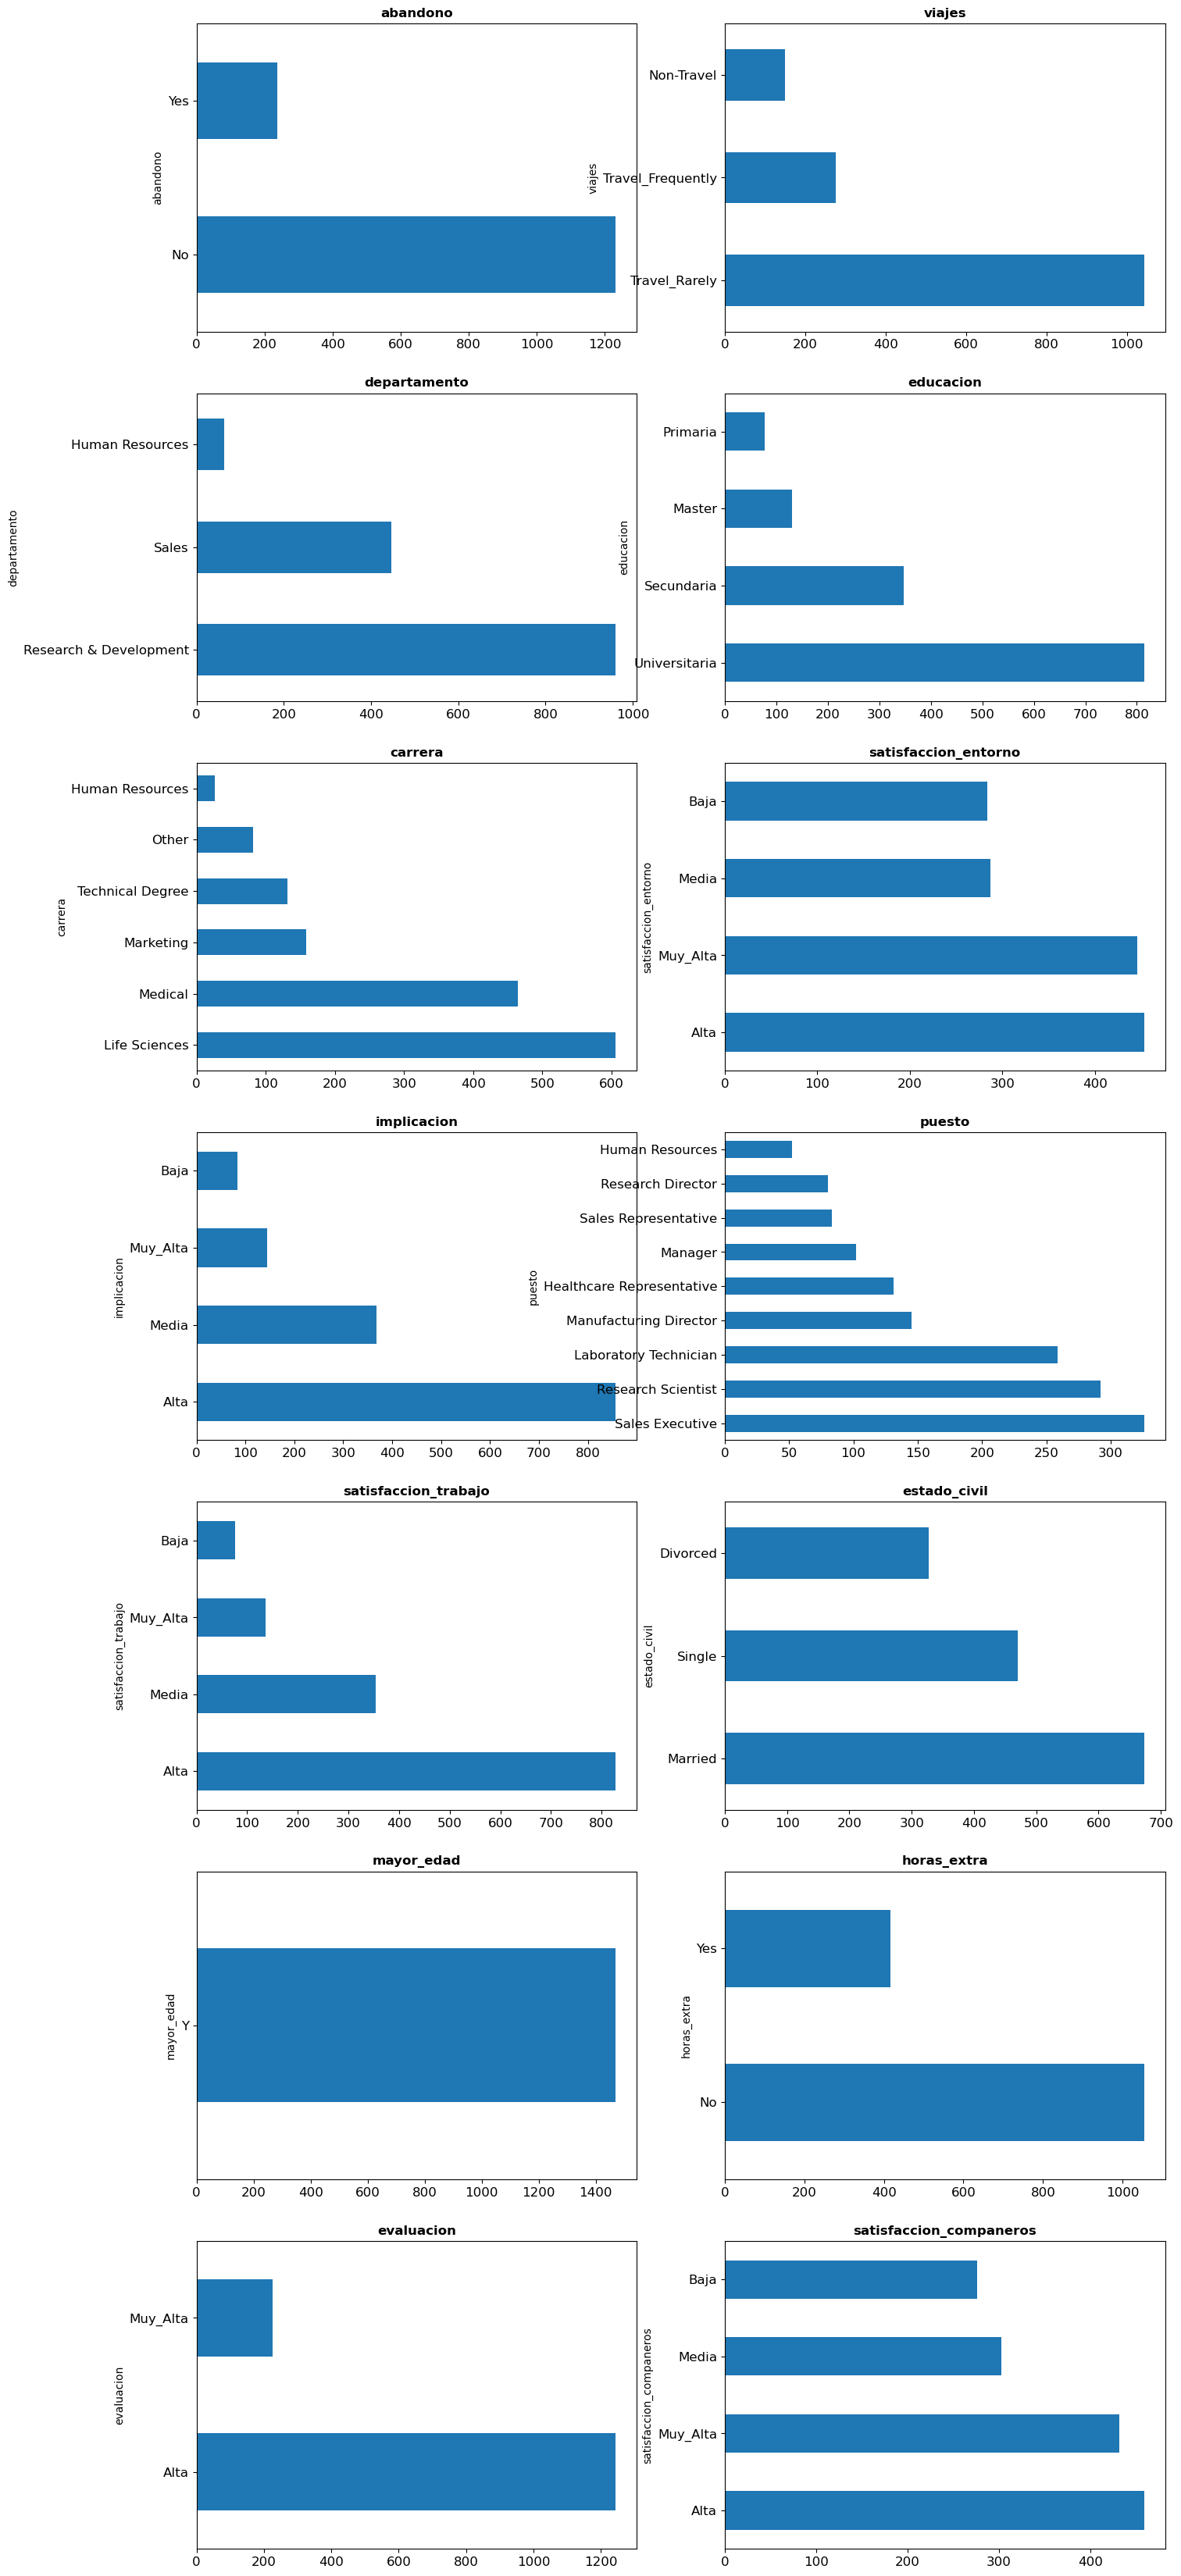

In [9]:
graficos_eda_categoricos(df.select_dtypes('O'))

Conclusiones:
* mayor_edad solo tiene un valor, tal que se elimina
* las imputaciones pendientes de variables categóricas:
    1) educacion: imputar por 'Universitaria'
    2) satisfaccion_trabajo: imputar por 'Alta'
    3) implicacion: imputar por 'Alta'

In [10]:
df.drop(columns = 'mayor_edad', inplace = True)

df['educacion'] = df['educacion'].fillna('Universitaria')

df['satisfaccion_trabajo'] = df['satisfaccion_trabajo'].fillna('Alta')

df['implicacion'] = df['implicacion'].fillna('Alta')

In [11]:
def estadisticos_cont(num):
    
    #Calculamos describe de los datos
    estadisticos = num.describe().T
    
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    
    #Entrega del resultado
    return(estadisticos)

In [12]:
estadisticos_cont(df.select_dtypes('number'))

,count,mean,median,std,min,25%,50%,75%,max
edad,1470.0,36.923810,36.0,9.135373,18.0,30.0,36.0,43.0,60.0
distancia_casa,1470.0,9.192517,7.0,8.106864,1.0,2.0,7.0,14.0,29.0
empleados,1470.0,1.000000,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
sexo,1271.0,2.727773,3.0,0.720788,1.0,2.0,3.0,3.0,4.0
nivel_laboral,1470.0,2.063946,2.0,1.106940,1.0,1.0,2.0,3.0,5.0
salario_mes,1470.0,6502.931293,4919.0,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
num_empresas_anteriores,1470.0,2.693197,2.0,2.498009,0.0,1.0,2.0,4.0,9.0
incremento_salario_porc,1470.0,15.209524,14.0,3.659938,11.0,12.0,14.0,18.0,25.0
horas_quincena,1470.0,80.000000,80.0,0.000000,80.0,80.0,80.0,80.0,80.0
nivel_acciones,1470.0,0.793878,1.0,0.852077,0.0,0.0,1.0,1.0,3.0


Con esto se puede concluir que:

* Empleados solo tiene un valor, tal que podemos eliminarla
* Sexo tiene 4 valores, sin embargo se decide eliminar esta variable dado que posee algunos valores nulos y de esta manera no tenemos que preocuparnos de impuratlos.
* Como horas quincena solo tiene una valor, se elimina dicha columna

In [14]:
df.drop(columns = ['empleados','sexo','horas_quincena'], inplace = True)

KeyError: "['empleados', 'sexo', 'horas_quincena'] not found in axis"

## Insights

### Cual es la tasa de abandono?

In [15]:
df.abandono.value_counts(normalize = True) * 100

abandono
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64

### Existe algun elementos en comun entre los empleados que abandonan? es decir un perfil

In [16]:
# Tratamos el abandono como una variable numerica
df['abandono'] = df.abandono.map({'No':0, 'Yes':1})

#### Analisis por educación

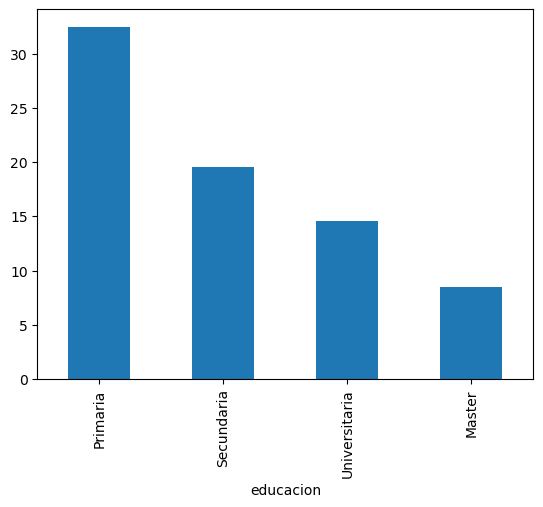

In [19]:
temp = df.groupby('educacion').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

#### Analisis por estado civil

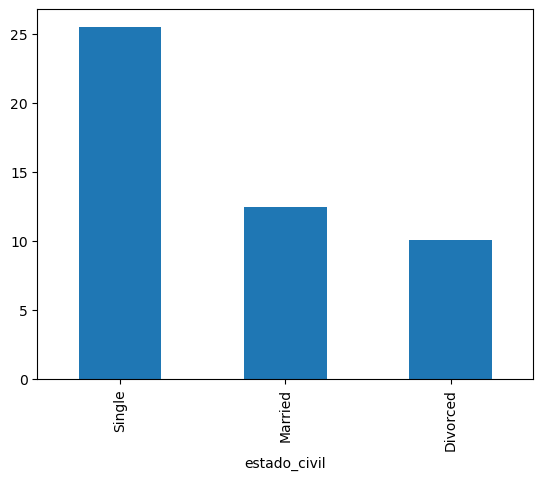

In [18]:
temp = df.groupby('estado_civil').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

#### Analisis por horas extras

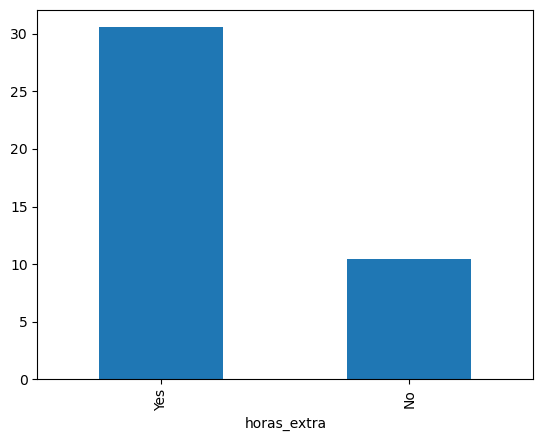

In [20]:
temp = df.groupby('horas_extra').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

#### Analisis por puesto

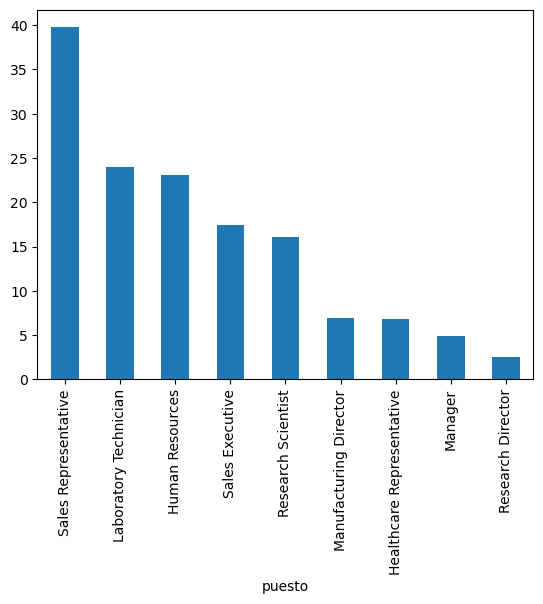

In [21]:
temp = df.groupby('puesto').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

#### Analisis por salario

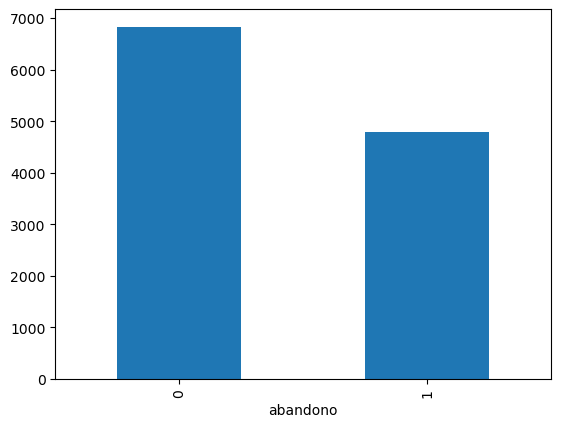

In [22]:
temp = df.groupby('abandono').salario_mes.mean()
temp.plot.bar();

Por lo tanto el perfil del empleado que deja la empresa se caracteriza por:

* Bajo nivel educativo
* Soltero
* Trabaja en ventas
* Bajo salario
* Alta carga de horas extras

### Cual es el impacto economico en la empresa?

Según el estudio "Cost of Turnover" del Center for American Progress:

* El coste de la fuga de los empleados que ganan menos de 30000 es del 16,1% de su salario
* El coste de la fuga de los empleados que ganan entre 30000-50000 es del 19,7% de su salario
* El coste de la fuga de los empleados que ganan entre 50000-75000 es del 20,4% de su salario
* El coste de la fuga de los empleados que ganan más de 75000 es del 21% de su salario

#### Salario anual

In [23]:
df['salario_ano'] = df.salario_mes.transform(lambda x: x*12)
df[['salario_mes','salario_ano']]

,salario_mes,salario_ano
id,,
1,5993,71916
2,5130,61560
4,2090,25080
5,2909,34908
7,3468,41616
...,...,...
2061,2571,30852
2062,9991,119892
2064,6142,73704


#### Impacto economico en la empresa tras la salida de un empleado

In [24]:
condiciones = [(df['salario_ano'] <= 30000),
               (df['salario_ano'] > 30000) & (df['salario_ano'] <= 50000),
               (df['salario_ano'] > 50000) & (df['salario_ano'] <= 75000),
               (df['salario_ano'] > 75000)]

#Lista de resultados
resultados = [df.salario_ano * 0.161, df.salario_ano * 0.197, df.salario_ano * 0.204, df.salario_ano * 0.21]

#Aplicamos select
df['impacto_abandono'] = np.select(condiciones,resultados, default = -999)

df

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,satisfaccion_entorno,implicacion,nivel_laboral,...,evaluacion,satisfaccion_companeros,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual,salario_ano,impacto_abandono
id,,,,,,,,,,,,,,,,,,,,,
1,41,1,Travel_Rarely,Sales,1,Universitaria,Life Sciences,Media,Alta,2,...,Alta,Baja,0,8,0,6,0,5,71916,14670.864
2,49,0,Travel_Frequently,Research & Development,8,Secundaria,Life Sciences,Alta,Media,2,...,Muy_Alta,Muy_Alta,1,10,3,10,1,7,61560,12558.240
4,37,1,Travel_Rarely,Research & Development,2,Secundaria,Other,Muy_Alta,Media,1,...,Alta,Media,0,7,3,0,0,0,25080,4037.880
5,33,0,Travel_Frequently,Research & Development,3,Universitaria,Life Sciences,Muy_Alta,Alta,1,...,Alta,Alta,0,8,3,8,3,0,34908,6876.876
7,27,0,Travel_Rarely,Research & Development,2,Universitaria,Medical,Baja,Alta,1,...,Alta,Muy_Alta,1,6,3,2,2,2,41616,8198.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,0,Travel_Frequently,Research & Development,23,Master,Medical,Alta,Muy_Alta,2,...,Alta,Alta,1,17,3,5,0,3,30852,6077.844
2062,39,0,Travel_Rarely,Research & Development,6,Secundaria,Medical,Muy_Alta,Media,3,...,Alta,Baja,1,9,5,7,1,7,119892,25177.320
2064,27,0,Travel_Rarely,Research & Development,4,Master,Life Sciences,Media,Muy_Alta,2,...,Muy_Alta,Media,1,6,0,6,0,3,73704,15035.616


#### Como ha impacto este problema en el ultimo año

In [25]:
coste_total =  df.loc[df.abandono == 1].impacto_abandono.sum()
coste_total

2719005.912

#### Como afecta economicamente la motivacion de los empleados

In [26]:
df.loc[(df.abandono == 1) & (df.implicacion == 'Baja')].impacto_abandono.sum()

368672.688

Cuanto se puede ahorrar mejorando la fidelidad de los empleados

In [28]:
print(f"Reducir un 10% la fuga de empleados nos ahorraría {int(coste_total * 0.1)}$ cada año.")
print(f"Reducir un 20% la fuga de empleados nos ahorraría {int(coste_total * 0.2)}$ cada año.")
print(f"Reducir un 30% la fuga de empleados nos ahorraría {int(coste_total * 0.3)}$ cada año.")

Reducir un 10% la fuga de empleados nos ahorraría 271900$ cada año.
Reducir un 20% la fuga de empleados nos ahorraría 543801$ cada año.
Reducir un 30% la fuga de empleados nos ahorraría 815701$ cada año.


## Estrategias para enfretar los problemas presentes

Los representantes de ventas son el puesto que más se van. ¿Tendría sentido hacer un plan específico para ellos? ¿Cual sería el coste ahorrado si disminuimos la fuga un 30%?
Vamos a calcular el % de representantes de ventas que se han ido el año pasado

In [29]:
total_repre_pasado = len(df.loc[df.puesto == 'Sales Representative'])
abandonos_repre_pasado = len(df.loc[(df.puesto == 'Sales Representative') & (df.abandono == 1)])
porc_pasado = abandonos_repre_pasado / total_repre_pasado

porc_pasado

0.39759036144578314

#### Cuántos se irán este año?

In [30]:
total_repre_actual = len(df.loc[(df.puesto == 'Sales Representative') & (df.abandono == 0)])
se_iran = int(total_repre_actual * porc_pasado)

se_iran

19

#### Cuanto dinero supondra su ida?

In [31]:
retenemos = int(se_iran * 0.3)

ahorramos = df.loc[(df.puesto == 'Sales Representative') & (df.abandono == 0),'impacto_abandono'].sum() * porc_pasado * 0.3

print(f'Podemos retener {retenemos} representantes de ventas y ello supondría ahorrar {ahorramos}$.')

Podemos retener 5 representantes de ventas y ello supondría ahorrar 37447.22424578312$.


## Machine Learning apporach

In [32]:
df_ml = df.copy()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   int64  
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1470 non-null   object 
 6   carrera                   1470 non-null   object 
 7   satisfaccion_entorno      1470 non-null   object 
 8   implicacion               1470 non-null   object 
 9   nivel_laboral             1470 non-null   int64  
 10  puesto                    1470 non-null   object 
 11  satisfaccion_trabajo      1470 non-null   object 
 12  estado_civil              1470 non-null   object 
 13  salario_mes               1470 non-null   int64  
 14  num_empresas_

### Transfomacion de las variable categoricas a numericas

In [34]:
#Categóricas
cat = df_ml.select_dtypes('O')

#Instanciamos
ohe = OneHotEncoder(sparse = False)

#Entrenamos
ohe.fit(cat)

#Aplicamos
cat_ohe = ohe.transform(cat)

#Ponemos los nombres
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out(input_features = cat.columns)).reset_index(drop = True)

C:\Users\matia\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
cat_ohe

,viajes_Non-Travel,viajes_Travel_Frequently,viajes_Travel_Rarely,departamento_Human Resources,departamento_Research & Development,departamento_Sales,educacion_Master,educacion_Primaria,educacion_Secundaria,educacion_Universitaria,...,estado_civil_Married,estado_civil_Single,horas_extra_No,horas_extra_Yes,evaluacion_Alta,evaluacion_Muy_Alta,satisfaccion_companeros_Alta,satisfaccion_companeros_Baja,satisfaccion_companeros_Media,satisfaccion_companeros_Muy_Alta
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1467,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Seleccion de las variables numericas del dataset original y union de las mismas para tener el dataset final.

In [36]:
num = df.select_dtypes('number').reset_index(drop = True)

In [37]:
df_ml = pd.concat([cat_ohe,num], axis = 1)
df_ml

,viajes_Non-Travel,viajes_Travel_Frequently,viajes_Travel_Rarely,departamento_Human Resources,departamento_Research & Development,departamento_Sales,educacion_Master,educacion_Primaria,educacion_Secundaria,educacion_Universitaria,...,num_empresas_anteriores,incremento_salario_porc,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual,salario_ano,impacto_abandono
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,8,11,0,8,0,6,0,5,71916,14670.864
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,23,1,10,3,10,1,7,61560,12558.240
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,6,15,0,7,3,0,0,0,25080,4037.880
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1,11,0,8,3,8,3,0,34908,6876.876
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,9,12,1,6,3,2,2,2,41616,8198.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4,17,1,17,3,5,0,3,30852,6077.844
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,4,15,1,9,5,7,1,7,119892,25177.320
1467,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,20,1,6,0,6,0,3,73704,15035.616
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2,14,0,17,3,9,0,8,64680,13194.720


### Separacion de las variables para ML

In [40]:
x = df_ml.drop(columns='abandono')
y = df_ml['abandono']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3)

### Entrenamiento del modelo

In [42]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=4)

### Prediccion y validacion

In [44]:
pred = model.predict_proba(test_x)[:, 1]
pred[:20]

array([0.06238185, 1.        , 0.06238185, 0.15204678, 0.15204678,
       0.48275862, 0.06238185, 0.06238185, 0.06238185, 0.15204678,
       0.06238185, 0.06238185, 0.11965812, 0.06238185, 0.06238185,
       0.11965812, 0.48275862, 0.15204678, 0.15204678, 0.42028986])

In [46]:
roc_auc_score(test_y,pred)

0.6977110745614035

### Diagrama del arbol

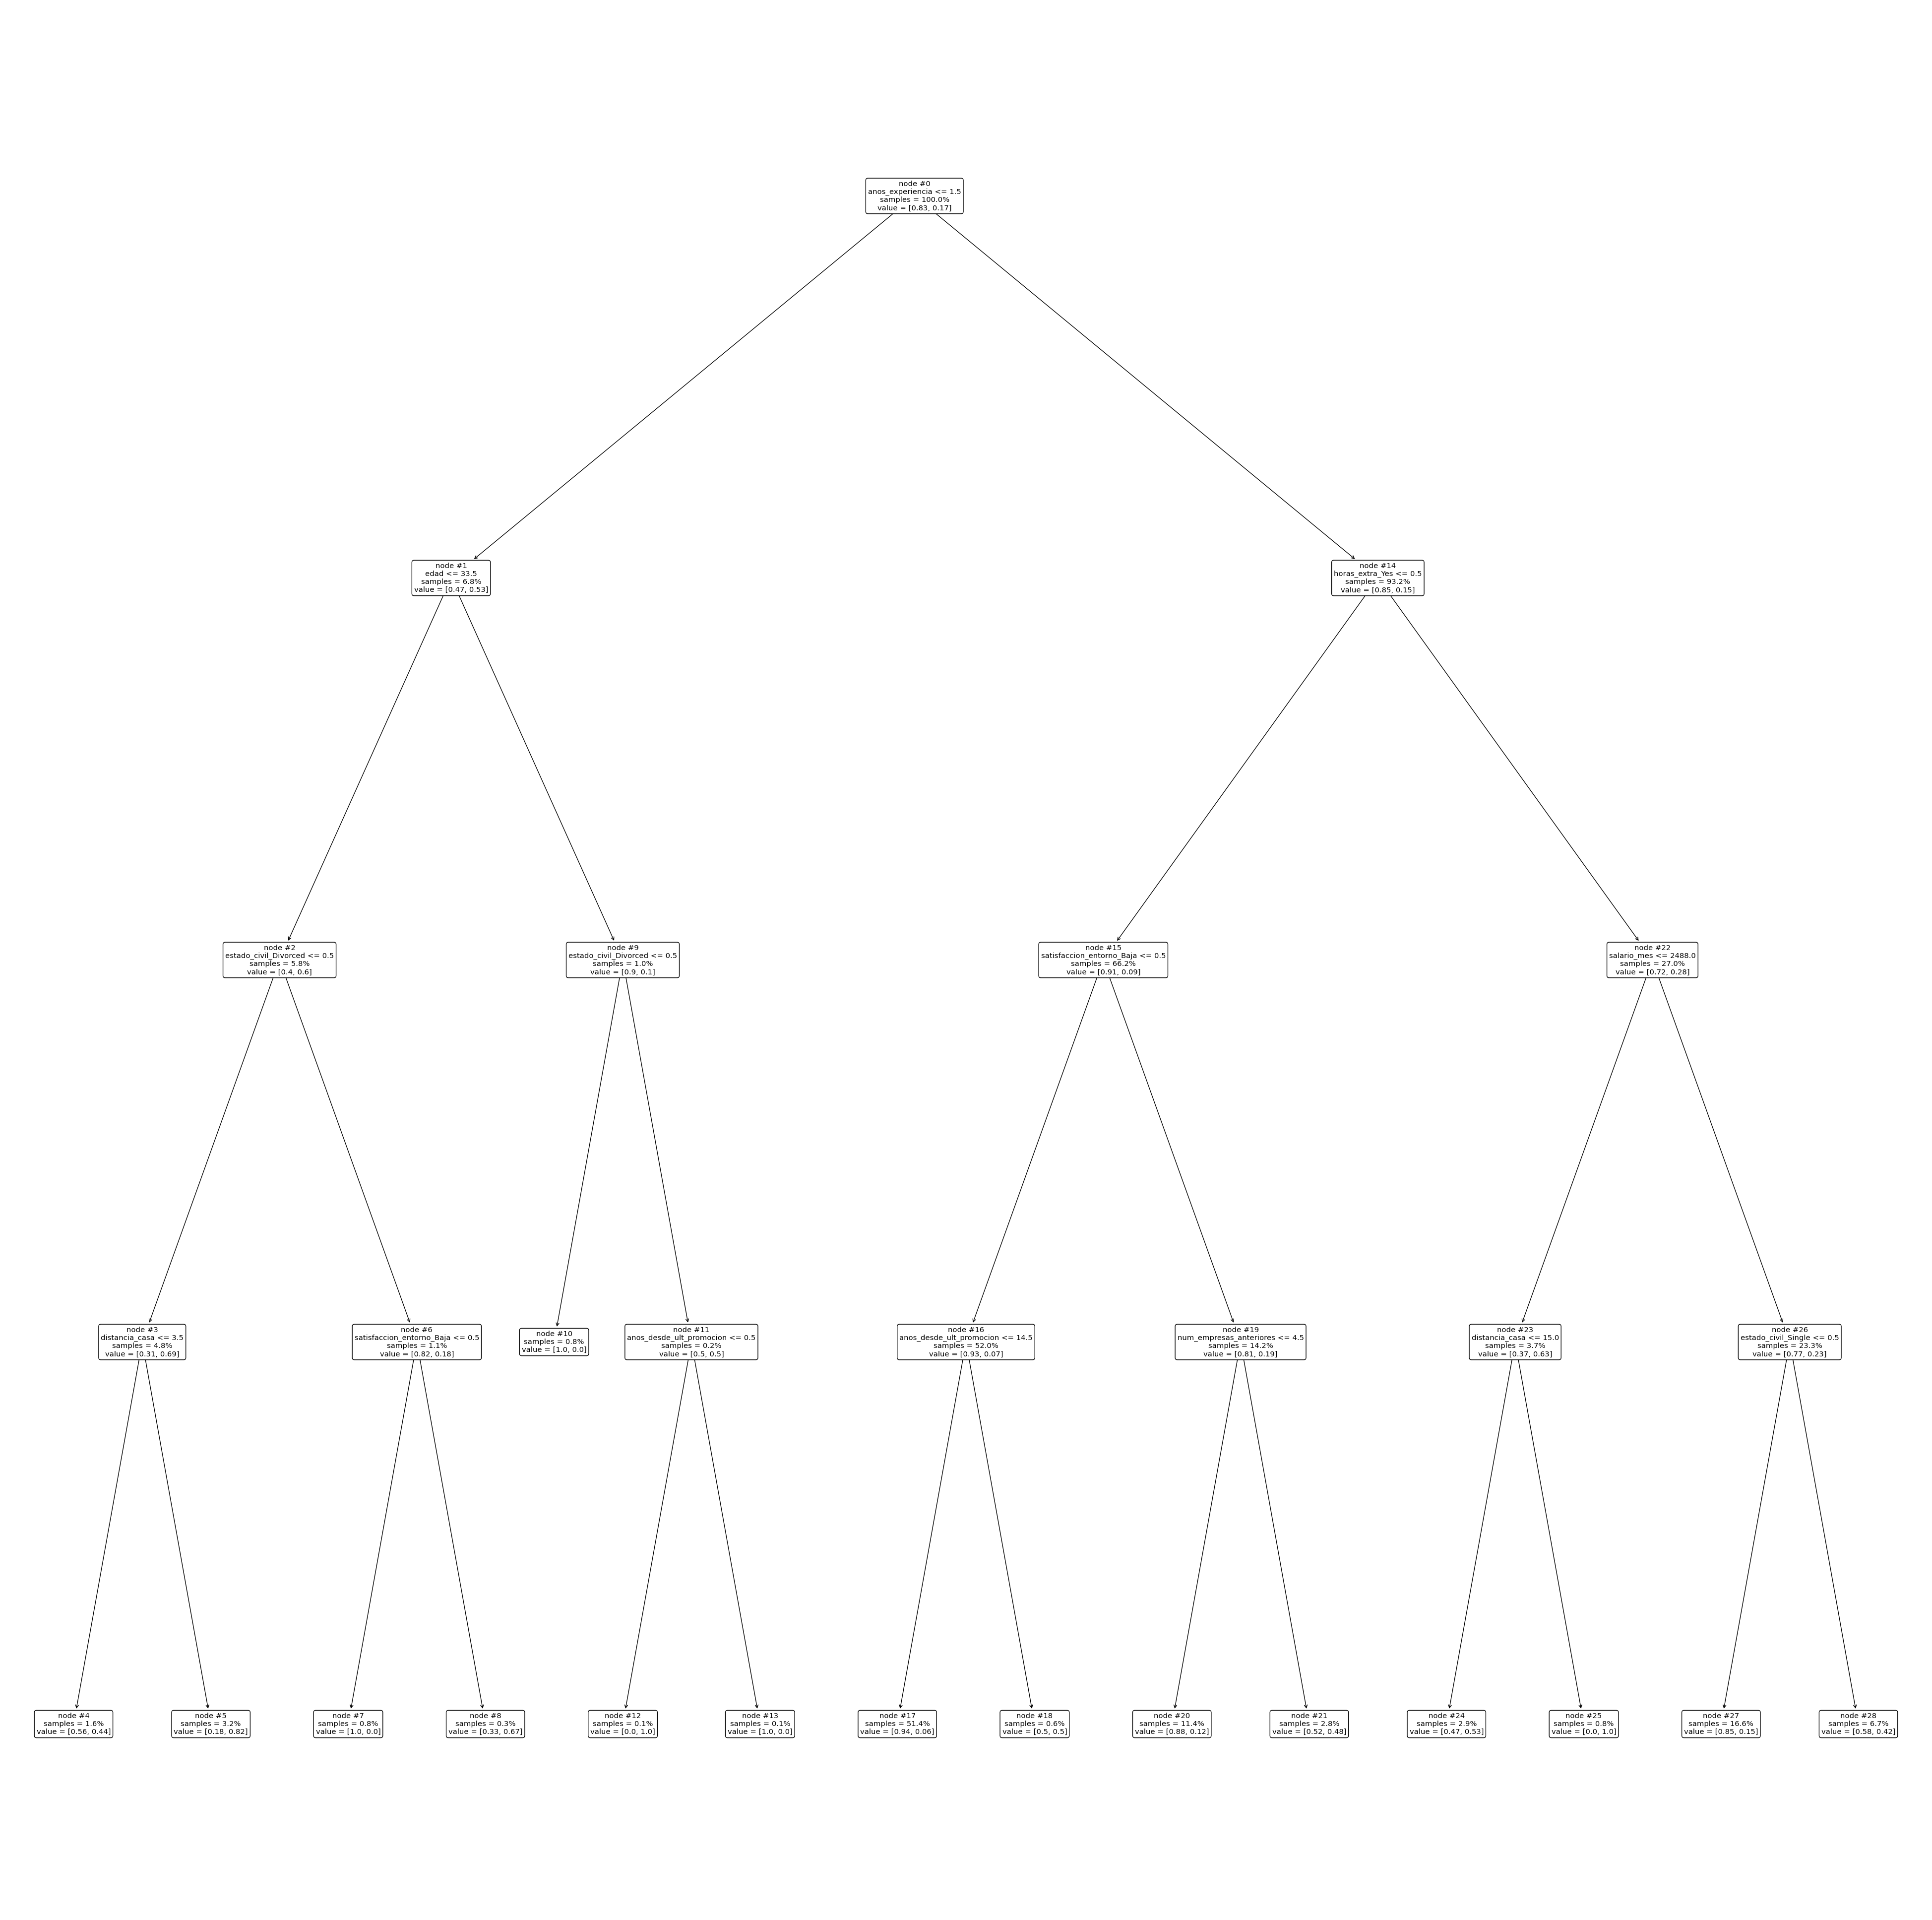

In [51]:
plt.figure(figsize = (50,50))

plot_tree(model,
          feature_names= test_x.columns.tolist(),
          impurity = False,
          node_ids = True,
          proportion = True,
          rounded = True,
          precision = 2);

### Importacion de las variables

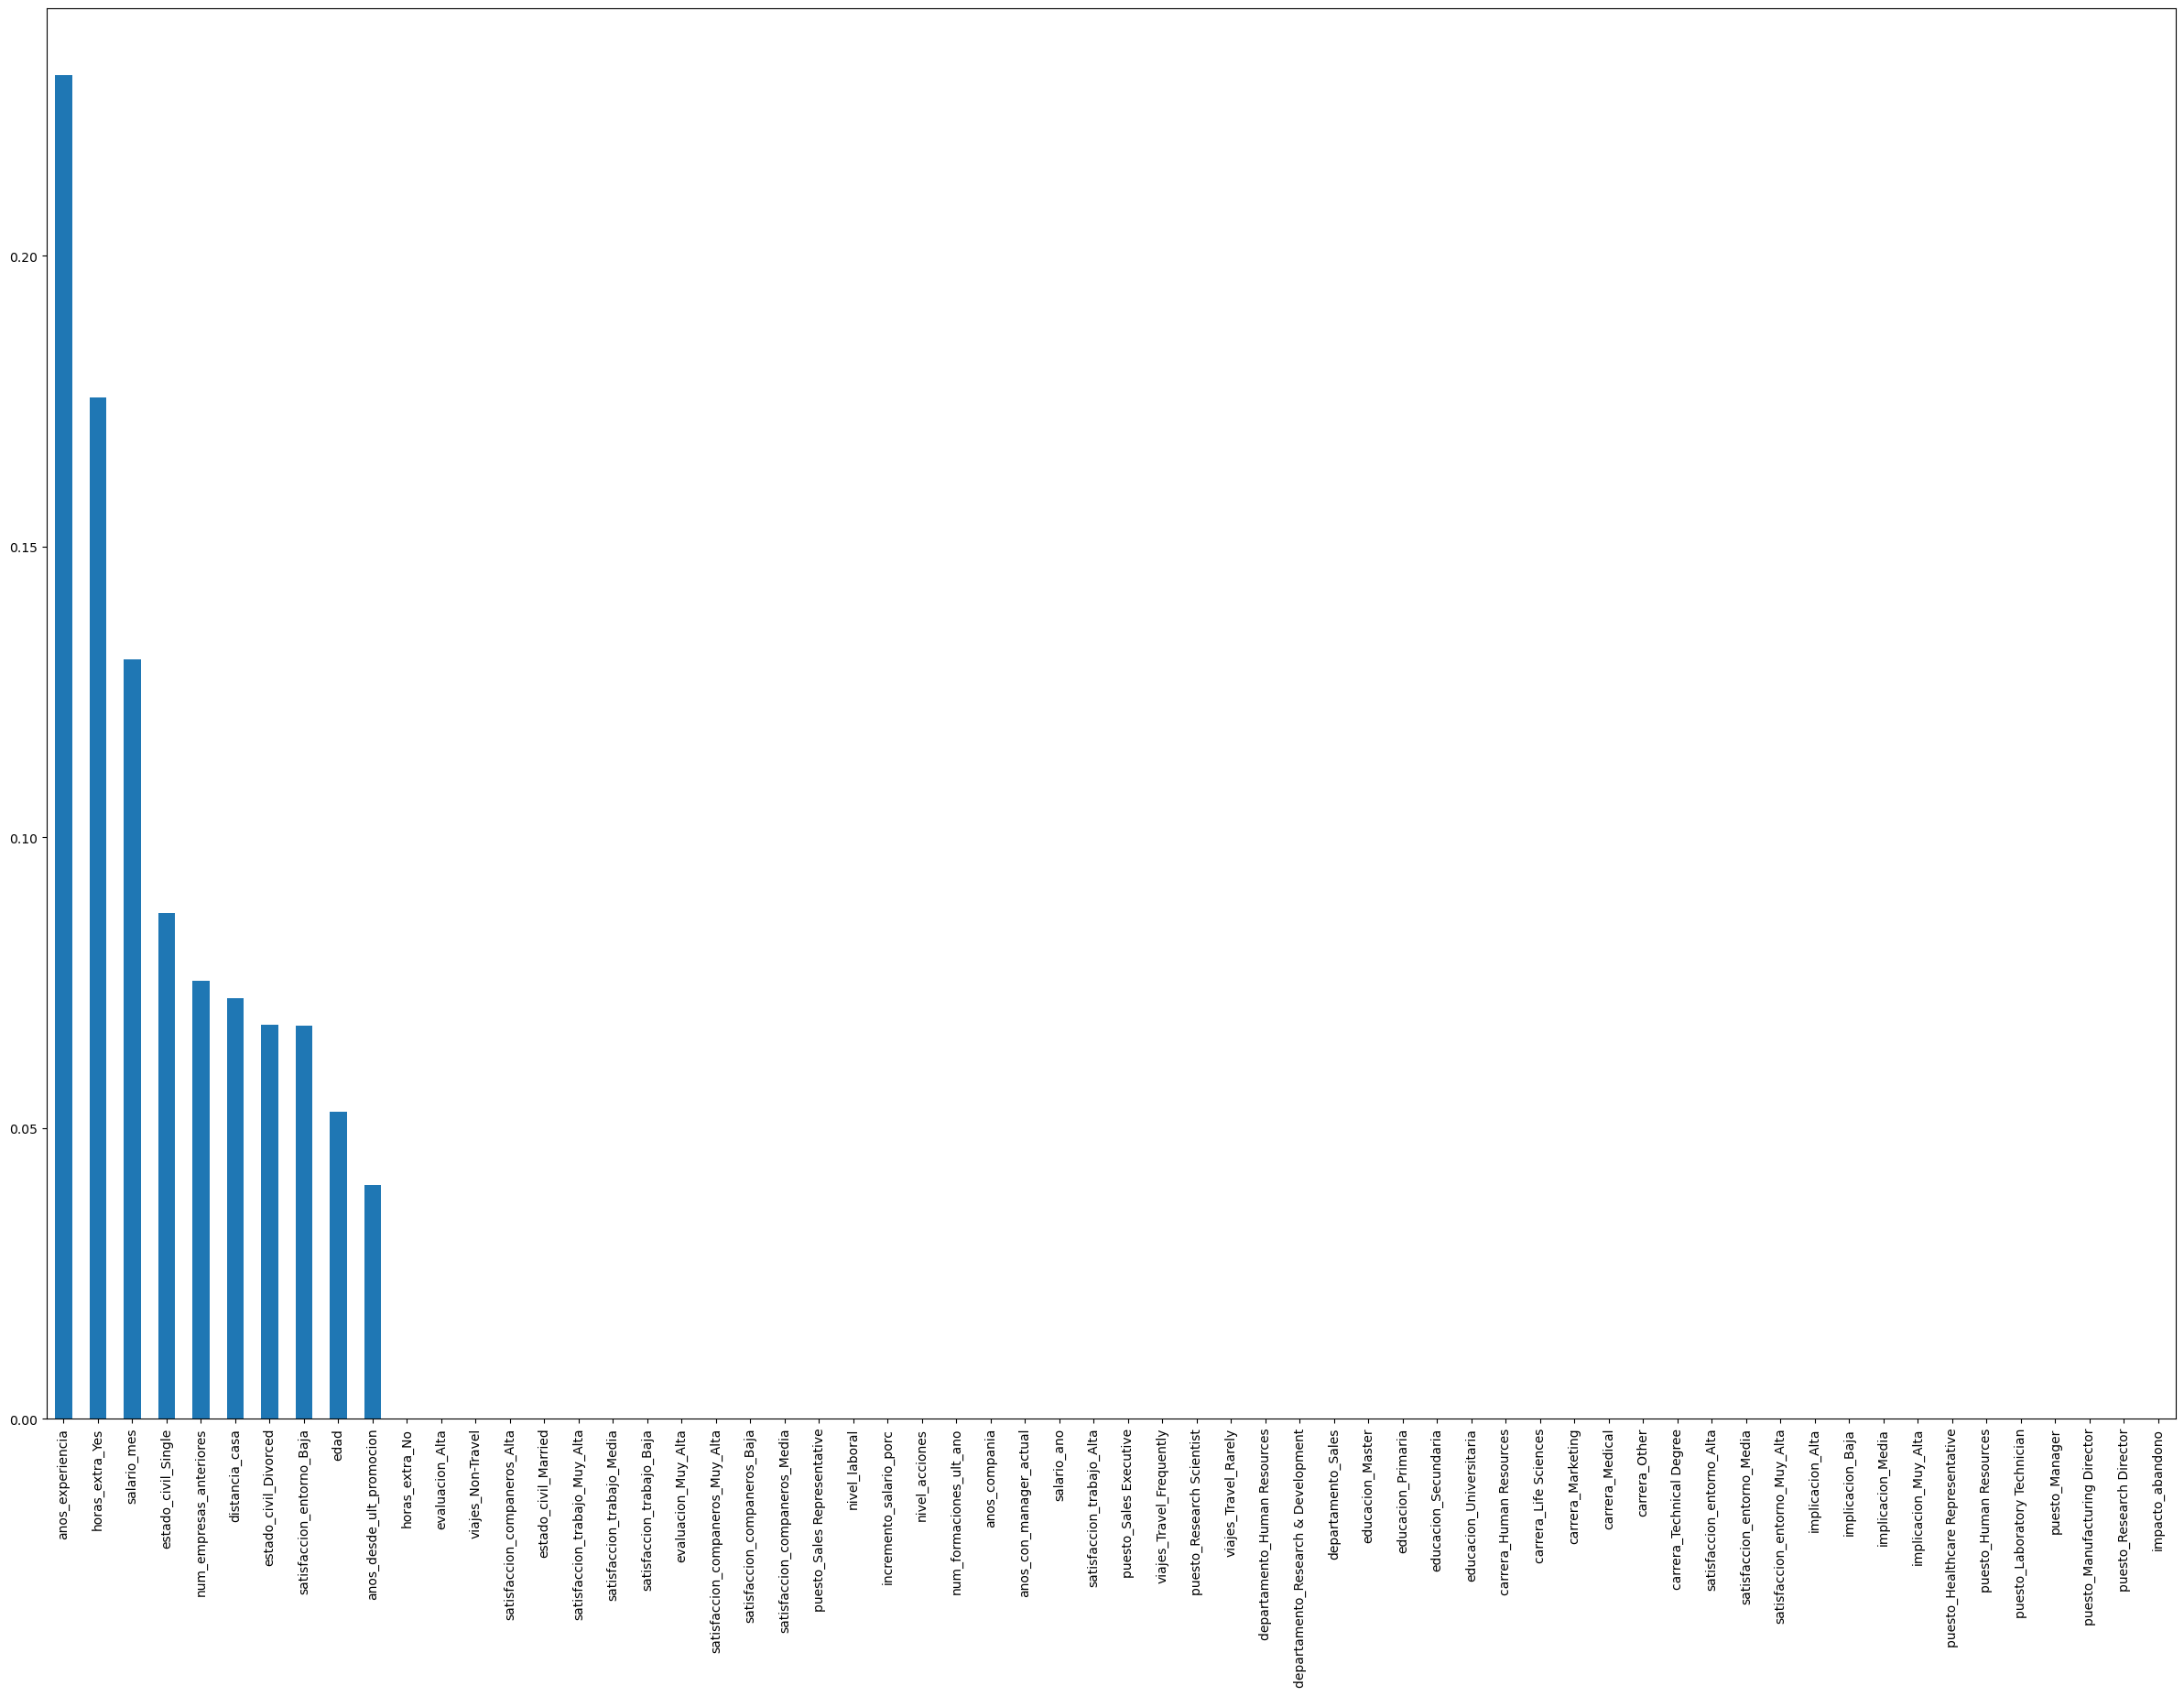

In [53]:
pd.Series(model.feature_importances_,index = test_x.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (30,20));

## Explotacion

### Incorporacion de la variable scoring

In [55]:
df['scoring_abandono'] = model.predict_proba(df_ml.drop(columns = 'abandono'))[:, 1]
df

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,satisfaccion_entorno,implicacion,nivel_laboral,...,satisfaccion_companeros,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual,salario_ano,impacto_abandono,scoring_abandono
id,,,,,,,,,,,,,,,,,,,,,
1,41,1,Travel_Rarely,Sales,1,Universitaria,Life Sciences,Media,Alta,2,...,Baja,0,8,0,6,0,5,71916,14670.864,0.420290
2,49,0,Travel_Frequently,Research & Development,8,Secundaria,Life Sciences,Alta,Media,2,...,Muy_Alta,1,10,3,10,1,7,61560,12558.240,0.062382
4,37,1,Travel_Rarely,Research & Development,2,Secundaria,Other,Muy_Alta,Media,1,...,Media,0,7,3,0,0,0,25080,4037.880,0.533333
5,33,0,Travel_Frequently,Research & Development,3,Universitaria,Life Sciences,Muy_Alta,Alta,1,...,Alta,0,8,3,8,3,0,34908,6876.876,0.152047
7,27,0,Travel_Rarely,Research & Development,2,Universitaria,Medical,Baja,Alta,1,...,Muy_Alta,1,6,3,2,2,2,41616,8198.352,0.482759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,0,Travel_Frequently,Research & Development,23,Master,Medical,Alta,Muy_Alta,2,...,Alta,1,17,3,5,0,3,30852,6077.844,0.062382
2062,39,0,Travel_Rarely,Research & Development,6,Secundaria,Medical,Muy_Alta,Media,3,...,Baja,1,9,5,7,1,7,119892,25177.320,0.062382
2064,27,0,Travel_Rarely,Research & Development,4,Master,Life Sciences,Media,Muy_Alta,2,...,Media,1,6,0,6,0,3,73704,15035.616,0.152047
